Данные
В результате у нас получилось 2 таблички:

Ответы наши сервиса с рекомендациями — в них мы знаем, какому пользователю что мы порекомендовали и в какую группу его отнесли. И, конечно, знаем момент времени, когда это произошло.
Данные о лайках — в них мы знаем, какой пользователь и какой пост лайкнул, в том числе момент времени, когда это произошло.

In [216]:
import pandas as pd

likes = pd.read_csv('likes.csv')
views = pd.read_csv('views.csv')

In [217]:
likes

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833
...,...,...,...
230171,31851,5964,1655243535
230172,51512,1498,1655243537
230173,34017,5009,1655243573
230174,13267,1787,1655243692


In [218]:
views


,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829
...,...,...,...,...
193290,158267,test,[1733 6834 4380 1915 1627],1655240340
193291,63527,control,[2454 191 3873 6404 1588],1655240347
193292,52169,test,[1368 1709 1616 798 5305],1655240354
193293,142402,test,[5895 6984 1978 6548 6106],1655240373


Во-первых, у нас нет таблички соответствия пользователь-группа, так как мы на самом деле определяли группу пользователя прямо перед подготовкой рекомендаций.

Может показаться, что это гарантирует нам однозначное соответствие групп для пользователей, но давайте это проверим. В реальности бывают лаги системы (например, если мы запрашиваем группу пользователя, то не всегда можем получить ответ) и это свойство не выполняется. Проверьте, нет ли у нас пользователей, которые попали в обе группы. Если их совсем немного, удалите их из обеих выборок (если бы было много, то надо было разбираться, что пошло не так).

### Удаляем юзеров попавших в обе группы, если таких немного

In [219]:
users_group = views.groupby('user_id')['exp_group'].nunique()
duplicated_users = users_group[users_group > 1].index
print(f'ID users witch were in both groups {duplicated_users}')

remove_views = views[~views['user_id'].isin(duplicated_users)]
remove_likes = likes[~likes['user_id'].isin(duplicated_users)]

ID users witch were in both groups Index([25623, 55788, 142283, 148670], dtype='int64', name='user_id')


In [220]:
remove_views.shape[0]

193268

### Теперь сделаем табличку пользователь-группа

In [221]:
df_user_group = remove_views[['user_id', 'exp_group']]
df_user_group 

,user_id,exp_group
0,128381,control
1,146885,test
2,50948,test
3,37703,test
4,14661,test
...,...,...
193290,158267,test
193291,63527,control
193292,52169,test
193293,142402,test


### Проведем биномиальный тест, чтобы проверить соответствие доли каждой группы с ожидаемым 0.5, то есть чтобы группы были с одинаковым количеством пользователей

In [222]:
from scipy.stats import binom

test_count = df_user_group[df_user_group['exp_group']=='test'].shape[0]
control_count = df_user_group[df_user_group['exp_group']=='control'].shape[0]
print(f'Размер тестовой группы: {test_count} \nРазмер контрольной группы: {control_count}')

total_count = df_user_group.shape[0]

alpha=0.05
p_value = stats.binom.sf(test_count, total_count, p=0.5) #Двустороннее распределение
print(f'p-value = {p_value:.3f}')

if p_value<alpha:
    print('Not equels groups')
else:
    print('Groups have the same number of users')

Размер тестовой группы: 96898 
Размер контрольной группы: 96370
p-value = 0.114
Groups have the same number of users


### Проверим, улучшаются ли метрики в тестовой группе. Посчитаем сколько пользователей, для которых мы строили рекомендации сделали хотя бы один лайк.

In [223]:
like_counts = remove_likes.groupby('user_id').size().reset_index(name='like')

# Убираем дубликаты по user_id перед merge
remove_views_unique = remove_views.drop_duplicates(subset=['user_id'])

recommendations = pd.merge(remove_views_unique, like_counts, on='user_id', how='left')
recommendations = recommendations.fillna(0)

cnt_user_like = recommendations[recommendations['like'] > 0].shape[0]
print(f'Доля пользователей с лайками: {cnt_user_like/recommendations.shape[0]:.2f}')


Доля пользователей с лайками: 0.89


In [224]:
recommendations.isnull().sum()

user_id            0
exp_group          0
recommendations    0
timestamp          0
like               0
dtype: int64

In [225]:
recommendations.shape[0]

65009

In [226]:
recommendations

,user_id,exp_group,recommendations,timestamp,like
0,128381,control,[3644 4529 4704 5294 4808],1654030803,7.0
1,146885,test,[1399 1076 797 7015 5942],1654030811,4.0
2,50948,test,[2315 3037 1861 6567 4093],1654030825,5.0
3,37703,test,[2842 1949 162 1588 6794],1654030826,6.0
4,14661,test,[2395 5881 5648 3417 673],1654030829,11.0
...,...,...,...,...,...
65004,80500,test,[1588 4629 1457 3691 1688],1655240212,1.0
65005,149686,test,[3203 6437 3681 2678 1629],1655240216,1.0
65006,3615,control,[1578 6326 906 2833 993],1655240322,1.0
65007,119630,test,[3143 599 4588 1577 7077],1655240337,1.0


### Посмотрим распределение лайков

<Axes: xlabel='like', ylabel='Count'>

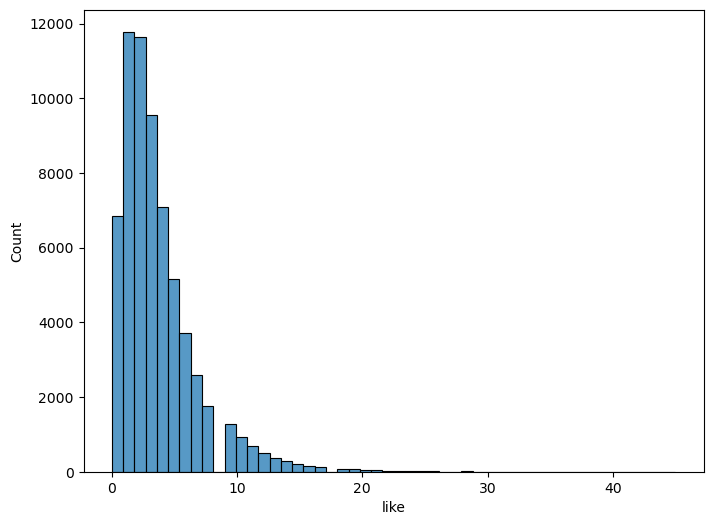

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.histplot(recommendations['like'], bins=50)

Видим, что распределение скошено.

### Через стат критерий проверим две метрики: 
    1. Доля пользователей хотя бы с 1 лайком - z test
    2. Число лайков на пользователя - Манна-Уитни-Уилкоксона

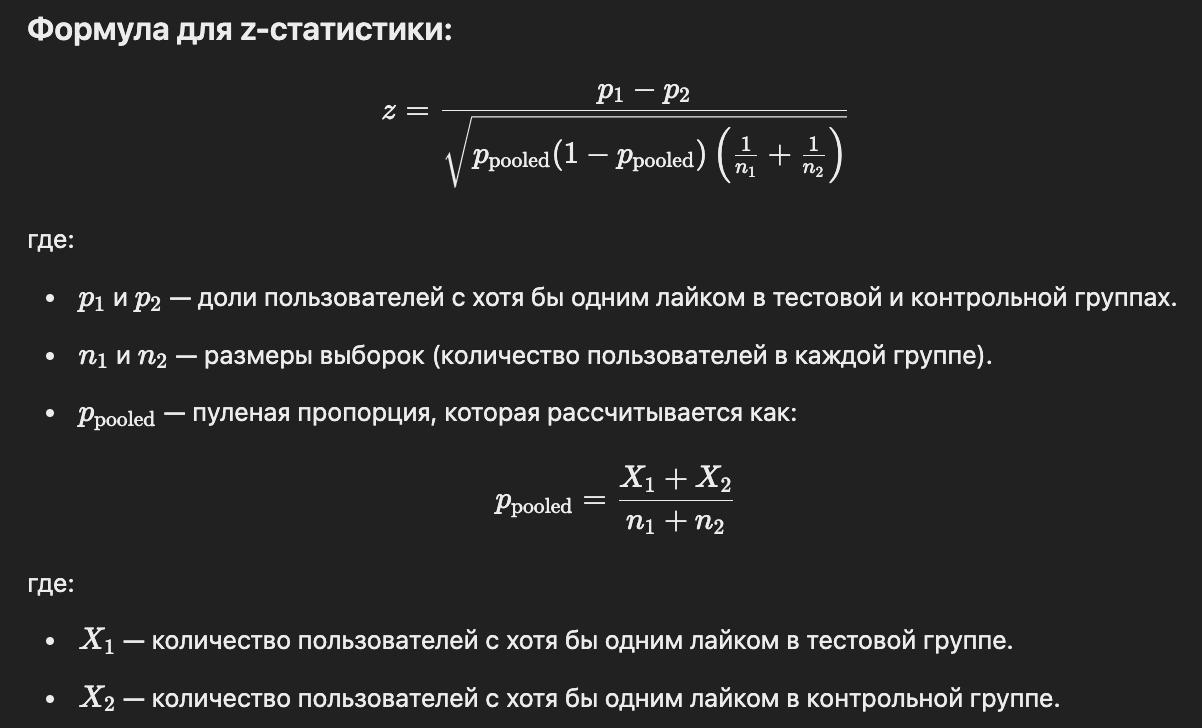

In [228]:
import numpy as np

df_test = recommendations[recommendations['exp_group']=='test']
df_control = recommendations[recommendations['exp_group']=='control']

n_test = df_test.shape[0]
n_control = df_control.shape[0]

p_test = df_test[df_test['like'] > 0].shape[0] / n_test
p_control = df_control[df_control['like'] > 0].shape[0] / n_control

x_test = df_test[df_test['like'] > 0].shape[0]
x_control = df_control[df_control['like'] > 0].shape[0]

p_pooled = (x_test + x_control) / (n_test + n_control)

z_stat = (p_test - p_control) / (np.sqrt(p_pooled * (1 - p_pooled) * (1/n_test + 1/n_control)))
print(f'z test = {z_stat}')

p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
print(f'p value = {p_value}')

alpha = 0.05
if p_value < alpha:
    print('Доли пользователей с хотя бы одним лайком различаются между группами.')
else:
    print('Доли пользователей с хотя бы одним лайком не различаются между группами.')

z test = 2.8440248969682322
p value = 0.0044547566854864495
Доли пользователей с хотя бы одним лайком различаются между группами.


In [229]:
from scipy.stats import mannwhitneyu

likes_per_user_test = recommendations[recommendations['exp_group'] == 'test']['like']
likes_per_user_control = recommendations[recommendations['exp_group'] == 'control']['like']

stat, p_value = mannwhitneyu(likes_per_user_test, likes_per_user_control, alternative='two-sided')

print(f"Статистика теста: {stat}")
print(f"p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print('Число лайков на пользователя различается между группами.')
else:
    print('Число лайков на пользователя не различается между группами.')


median_test = likes_per_user_test.median()
median_control = likes_per_user_control.median()

print(f"Медиана для тестовой группы: {median_test}")
print(f"Медиана для контрольной группы: {median_control}")

if median_test > median_control:
    print("Число лайков на пользователя улучшилось в тестовой группе.")
elif median_test < median_control:
    print("Число лайков на пользователя ухудшилось в тестовой группе.")
else:
    print("Число лайков на пользователя не изменилось между группами.")



Статистика теста: 538160577.0
p-value: 2.9585062792441953e-05
Число лайков на пользователя различается между группами.
Медиана для тестовой группы: 3.0
Медиана для контрольной группы: 3.0
Число лайков на пользователя не изменилось между группами.


Видим, что статистика показывает, что изменения существенны в обеих группах в лучшую сторону

### Теперь будем считать HitRate

У нас нет айдишника, по которому мы можем сджойнить, но есть два других способа сделать это:

1. По каждому пользователю отсортировать в обратном по времени порядке все лайки и показы рекомендаций (удобнее прямо в одном списке). Далее в цикле пробежаться по этому списку. Если мы встречаем лайк, то запоминаем его (лайков может быть несколько подряд, надо сохранить все). Если мы встречаем показ рекомендаций, то сохраняем его вместе с уже сохранёнными лайками (так как эти лайки следуют за этим показом рекомендаций в "обычном направлении времени"), при этом список сохранёных лайков очищаем (мы уже приписали эти лайки другим показам). Тем самым мы соединим все показы рекомендаций со всеми лайками после них. Нужно только ещё следить за тем, что может быть лайк, который случился через большое время после показа рекомендаций — скорее всего, мы потеряли другой показ рекомендаций, поэтому такой лайк не надо учитывать.


2. Сделать join по пользователям всех лайков и всех показов рекомендаций (то есть у нас появятся пары всех показов и всех лайков одного и того же пользователя, но не все эти пары реальны). Далее отфильтровать те ситуации, где лайк предшествовал показу рекомендаций (то есть относился на самом деле к другому показу) или был слишком поздно (тоже относится к другому показу).

Оба эти способа не идеальные и довольно муторные. В pandas проще сделать второй из них. В качестве проверки "лайк произошёл слишком поздно после рекомендации" возьмите отсечку 1 час (только лучше сначала просто помечать такие показы, как "отсутствие лайка", потому что если совсем удалять, то можно потерять показ). Добавьте также фильтрацию на то, что в рекомендациях был пост, на который пользователь лайкнул (иначе это точно был другой показ). В самом конце проведите уникализацию всех этих пар в строки показ-лайки (количество лайков может быть нулевым).

На каждом этапе фильтрации следите за размерами таблиц, это поможет вам убедиться, что происходит что-то корректное. Не забудьте учесть тот факт, что могут быть показы рекомендаций без лайков (либо через тип join, либо добавить эти строки в конце). В итоге число строк должно быть похожим на то, которые было сначала в табличке с показами.
 Посчитайте долю показов, в которых был хотя бы один лайк.

Делаем так:

1. Объединяем два датафрейма - с показами и кликами. Нужно подобрать такой джойн, чтобы остались и показы без кликов.

2. Разбиваем значения в списке рекомендаций на отдельные - могут помочь [.str.split()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html), [str.replace()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html)

3. Помечаем все **ненужные** нам посты. Это те, у которых **нет id** (стоит пропуск в `post_id`), которые **лайкнули позже, чем через час**, в которых **просмотр оказался позже лайка**, а также те, которые **не рекомендовали**

4. Самое сложное: для каждого юзера/поста/просмотра подбираем количество лайков, связанное именно с этой комбинацией. То есть лайкнул человек этот пост после показа или нет, 1 или 0, True или False. При этом учитывайте условия из прошлого шага - все эти варианты считаются за 0/False. Вот это и будет наш **hitrate**

5. Остаётся лишь посчитать относительную частоту лайкания



Помечаем все ненужные нам посты. Это те, у которых нет id (стоит пропуск в post_id), которые лайкнули позже, чем через час, в которых просмотр оказался позже лайка, а также те, которые не рекомендовали

In [311]:
df = pd.merge(remove_views, remove_likes, on='user_id', how='left')

In [312]:
# Преобразование временных меток в формат datetime
df['timestamp_x'] = pd.to_datetime(df['timestamp_x'])
df['timestamp_y'] = pd.to_datetime(df['timestamp_y'], errors='coerce')

df['recommendations'] = df['recommendations'].astype(str)
df['recommendations'] = df['recommendations'].str.replace(r'[\[\]]', '', regex=True)
df['recommendations'] = df['recommendations'].str.split()

df['recommendations'] = df['recommendations'].apply(lambda x: list(map(int, x)))
df['post_id'] = df['post_id'].astype('Int64')
df

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",1970-01-01 00:00:01.654030803,4704,1970-01-01 00:00:01.654030804
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",1970-01-01 00:00:01.654030803,5294,1970-01-01 00:00:01.654030838
2,128381,control,"[3644, 4529, 4704, 5294, 4808]",1970-01-01 00:00:01.654030803,3608,1970-01-01 00:00:01.655049327
3,128381,control,"[3644, 4529, 4704, 5294, 4808]",1970-01-01 00:00:01.654030803,2542,1970-01-01 00:00:01.655049342
4,128381,control,"[3644, 4529, 4704, 5294, 4808]",1970-01-01 00:00:01.654030803,4165,1970-01-01 00:00:01.655052806
...,...,...,...,...,...,...
1016884,52169,test,"[1368, 1709, 1616, 798, 5305]",1970-01-01 00:00:01.655240354,1709,1970-01-01 00:00:01.655240369
1016885,142402,test,"[5895, 6984, 1978, 6548, 6106]",1970-01-01 00:00:01.655240373,6548,1970-01-01 00:00:01.655240374
1016886,72259,control,"[6117, 1255, 6567, 3587, 3811]",1970-01-01 00:00:01.655240388,1712,1970-01-01 00:00:01.654305111
1016887,72259,control,"[6117, 1255, 6567, 3587, 3811]",1970-01-01 00:00:01.655240388,5070,1970-01-01 00:00:01.654308590


In [313]:
df['is_valid'] = True

df.loc[df['post_id'].isna(), 'is_valid'] = False  # Нет id поста
df.loc[(df['timestamp_y'] - df['timestamp_x']) > pd.Timedelta(hours=1), 'is_valid'] = False  # Лайк позднее, чем через час
df.loc[df['timestamp_x'] > df['timestamp_y'], 'is_valid'] = False  # Просмотр был позже лайка

df_exploded = df.explode('recommendations')
df['is_valid'] &= df.set_index(['post_id', df.index]).index.isin(df_exploded.set_index(['recommendations', df_exploded.index]).index)

df['liked'] = df['is_valid'].astype(int) 

# Агрегация
df_grouped = df.groupby(['user_id', 'exp_group', 'timestamp_x'])['liked'].max().reset_index()

total_shows = len(df_grouped)  
total_likes = df_grouped['liked'].sum() 

hitrate_overall = total_likes / total_shows  

print(f"Общий hitrate: {hitrate_overall:.2%}")


Общий hitrate: 71.38%


### Оценим различие между группами и значимость

z-критерий для долей мы здесь не можем применять, так как у нас в каждой выборке один и тот же пользователь может встречаться несколько раз. Давайте применим бакетный подход (то есть перейдём к бакетам и по ним оценим значимость), чтобы посчитать групповой hitrate (или CTR) — доля hitrate по группе/бакету. Используйте 100 бакетов. Уровень значимости останется тем же на уровне 0.05.

In [314]:
import hashlib

df_grouped['bucket'] = df['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'my_solt').encode()).hexdigest(), 16) % 100
)

alpha=0.05

#HitRate
df_buckets = df_grouped.groupby(['exp_group', 'bucket'])['liked'].mean().reset_index()

df_buckets_test = df_buckets[df_buckets['exp_group'] == 'test']['liked']
df_buckets_control = df_buckets[df_buckets['exp_group'] == 'control']['liked']

t_stats, p_value = stats.ttest_ind(df_buckets_test, df_buckets_control)

print(f'Статистика Т-тесат: {t_stats}')
print(f'p-value = {p_value}')

if p_value < alpha:
    print('Различие между группами статистически значимо')
else:
    print('Различие между группами незначительно')

Статистика Т-тесат: 5.950545438007389
p-value = 1.1950199981453349e-08
Различие между группами статистически значимо


In [315]:
# Считаем hitrate для каждой группы до бакетирования
hitrate_control_before = df_grouped[df_grouped['exp_group'] == 'control']['liked'].mean()
hitrate_test_before = df_grouped[df_grouped['exp_group'] == 'test']['liked'].mean()

# Считаем hitrate для каждой группы после бакетирования (по бакетам)
df_buckets = df_grouped.groupby(['exp_group', 'bucket'])['liked'].mean().reset_index()
hitrate_control_after = df_buckets[df_buckets['exp_group'] == 'control']['liked'].mean()
hitrate_test_after = df_buckets[df_buckets['exp_group'] == 'test']['liked'].mean()

# Разница в процентных пунктах
diff_control = hitrate_control_after - hitrate_control_before
diff_test = hitrate_test_after - hitrate_test_before

print(f"Hitrate в контрольной группе до бакетирования: {hitrate_control_before:.2%}")
print(f"Hitrate в контрольной группе после бакетирования: {hitrate_control_after:.2%}")
print(f"Разница для контрольной группы: {diff_control:.2%}")

print(f"Hitrate в тестовой группе до бакетирования: {hitrate_test_before:.2%}")
print(f"Hitrate в тестовой группе после бакетирования: {hitrate_test_after:.2%}")
print(f"Разница для тестовой группы: {diff_test:.2%}")


Hitrate в контрольной группе до бакетирования: 70.71%
Hitrate в контрольной группе после бакетирования: 70.74%
Разница для контрольной группы: 0.03%
Hitrate в тестовой группе до бакетирования: 72.04%
Hitrate в тестовой группе после бакетирования: 72.06%
Разница для тестовой группы: 0.02%
